# Plotting visualization and prototypes that seems to make sense

In [100]:
import numpy as np
from matplotlib import rc
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import sys
import torch

sys.path.append("./")
sys.path.append("../../")

from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering

from clustering.cluster import cluster_dataset, cluster_similarity_matrix, create_prototypes
from sklearn.preprocessing import StandardScaler

from electricity.data import ElectricityDataSet
from representations.representations import calculate_pca, calculate_sarima, calculate_tsne, calculate_embedded_id, calculate_representation
from similarities.similarities import calculate_similarity_matrix
from clustering.cluster import create_prototypes

In [101]:
rc("text", usetex=True)
ts_style = {
    "axes.spines.left": True,
    "axes.spines.right": False,
    "axes.spines.bottom": True,
    "axes.spines.top": False,
    "axes.grid": False,
    "xtick.bottom": True,
    "ytick.left": True,
}
cluster_style = {
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.bottom": False,
    "axes.spines.top": False,
    "axes.grid": False,
    "xtick.bottom": False,
    "ytick.left": False,
}

In [102]:
dataset_scaled = ElectricityDataSet(
    "electricity/data/electricity.npy",
    data_scaler=None,
    data_scale=True,
    start_date="2012-01-01",
    end_date="2014-12-16",
    predict_ahead=1,
    h_batch=0,
    receptive_field=385,
    cluster_covariate=False,
    random_covariate=False,
    cluster_dict_path=None,
)
dataset_unscaled = ElectricityDataSet(
    "electricity/data/electricity.npy",
    data_scaler=None,
    data_scale=False,
    start_date="2012-01-01",
    end_date="2014-12-16",
    predict_ahead=1,
    h_batch=0,
    receptive_field=385,
    cluster_covariate=False,
    random_covariate=False,
    cluster_dict_path=None,
)
dataset_scaled = dataset_scaled.X.squeeze().detach().numpy()
dataset_unscaled = dataset_unscaled.X.squeeze().detach().numpy()
dataset_scaled[1], dataset_unscaled[1], dataset_scaled.shape, dataset_unscaled.shape

Dimension of X :  torch.Size([370, 1, 25944])
Dimension of Y :  torch.Size([370, 1, 25944])
Dimension of X :  torch.Size([370, 1, 25944])
Dimension of Y :  torch.Size([370, 1, 25944])


(array([-0.7775993 , -0.72219676, -0.7498785 , ..., -0.55606717,
        -0.8883653 , -1.1929427 ], dtype=float32),
 array([91.038, 92.461, 91.75 , ..., 96.728, 88.193, 80.37 ], dtype=float32),
 (370, 25944),
 (370, 25944))

## Cluster

In [103]:
algorithm = "KMeans"
num_clusters = 10
representation = "raw"
scaled_representation = True
num_components = 10
similarity = "correlation"

In [104]:
if algorithm == "KMeans":
    method = KMeans(n_clusters=num_clusters)
    dist_or_sim_or_feat = "feat"
elif algorithm in ("Agglomerative"):
    method = AgglomerativeClustering(
        n_clusters=num_clusters, affinity="precomputed", linkage="average"
    )
    dist_or_sim_or_feat = "dist"
elif algorithm in ("Spectral clustering"):
    method = SpectralClustering(
        n_clusters=num_clusters, affinity="precomputed"
    )
    dist_or_sim_or_feat = "sim"

""" Representation """
if scaled_representation:
    rep = calculate_representation(
        dataset_scaled,
        representation=representation,
        num_components=num_components,
        dataset="electricity"
    )
else:
    rep = calculate_representation(
        dataset_unscaled,
        representation=representation,
        num_components=num_components,
        dataset="electricity"
    )

""" Similarity """
if dist_or_sim_or_feat == "feat":
    D = rep
    S = calculate_similarity_matrix(rep, metric=similarity, dist_or_sim="dist")
else:
    D = calculate_similarity_matrix(rep, metric=similarity, dist_or_sim=dist_or_sim_or_feat)
    S = D


""" Clustering """
clusters = method.fit_predict(D)
cluster_dist = {
    c: len(clusters[np.where(clusters == c)]) for c in range(len(set(clusters)))
}
for k, v in cluster_dist.items():
    print(f"{k:2} : {v}")
cluster_dict = {i: clusters[i] for i in range(len(clusters))}


Num components  10
No such representation available, Rep = raw.
 0 : 9
 1 : 125
 2 : 63
 3 : 15
 4 : 31
 5 : 23
 6 : 21
 7 : 14
 8 : 4
 9 : 65


## Visualizing clustering

In [105]:
emb_scaled = calculate_tsne(dataset_scaled, num_components=2)
emb_unscaled = calculate_tsne(dataset_unscaled, num_components=2)

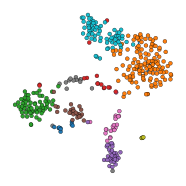

In [106]:
with plt.style.context(cluster_style):
    colors = [v for k, v in cluster_dict.items()]
    plt.figure(figsize=(4.77/2, 4.77/2))
    ax = plt.axes([0., 0., 1., 1.])
    plt.scatter(emb_scaled[:,0], emb_scaled[:,1], c = colors, cmap="tab10", edgecolors="black", s=15, linewidth=0.3)
    plt.xticks([])
    plt.yticks([])

    # Display a graph of the partial correlations
    non_zero = (np.abs(np.triu(np.exp(-S), k=1)) > 0.94)

    # Plot the edges
    start_idx, end_idx = np.where(non_zero)
    segments = [[emb_scaled[start, :], emb_scaled[stop, :]] for start, stop in zip(start_idx, end_idx)]
    lc = LineCollection(segments, zorder=0)
    ax.add_collection(lc)
    plt.tight_layout()
    #plt.savefig(f"Figures/electricity_proposed_clustering_edges.pdf", bbox_inches="tight")
    plt.show()

## Visualizing prototypes

In [107]:
prototypes, _, _ = create_prototypes(clusters, dataset_scaled)
cluster_dict = {i: clusters[i] for i in range(len(clusters))}
plot_index = np.random.randint(0, len(prototypes[0]) - length)

In [108]:
length=120
date_range = pd.date_range(start="2012-01-01", periods=dataset_scaled.shape[1], freq="H")
len_series = min([len(p) for p in prototypes.values()])
size=4.77*2
height = 2
scale_plot = True
fill_area = True

In [109]:
from matplotlib import cm
cmap=cm.get_cmap("tab10")
cmap(1.1)

(0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0)

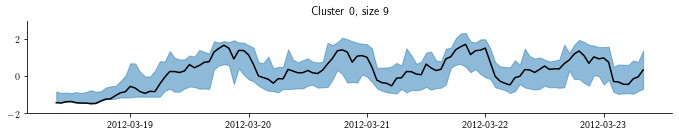

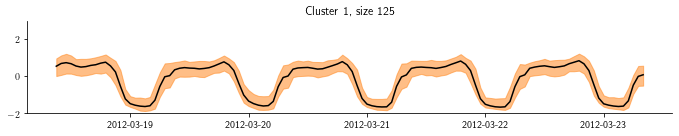

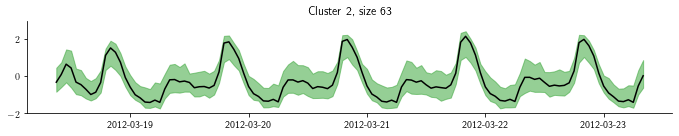

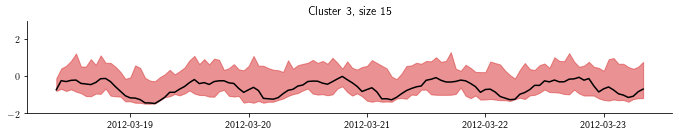

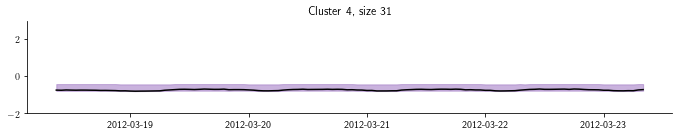

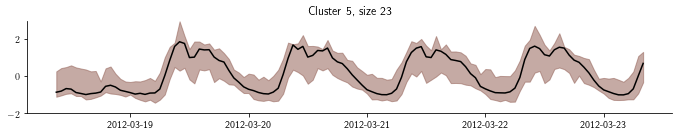

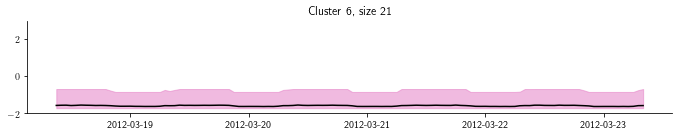

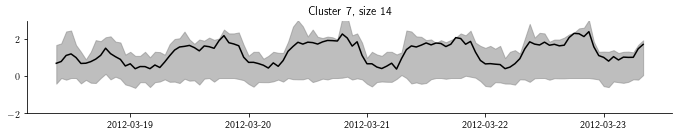

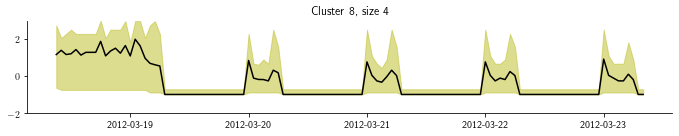

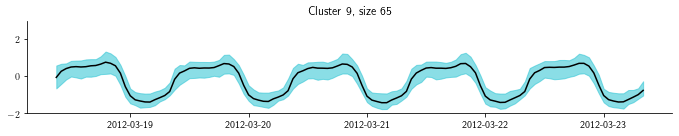

In [110]:
with plt.style.context(ts_style):
    for c in set(cluster_dict.values()):
        p = prototypes[c]
        members = {f"prot_{c}":p}
        for ts in cluster_dict.keys():
            if cluster_dict[ts] == c:
                members[str(ts)] = dataset_unscaled[ts]
        df = pd.DataFrame(members)
        if scale_plot:
            df[df.columns] = StandardScaler().fit_transform(df[df.columns])
        df.index = date_range
        df = df[plot_index : plot_index + length]
        plt.figure(figsize=(size, height))
        if not fill_area:
            rgba_colors = np.zeros((len(df), 4))
            rgba_colors[0,3] = 1
            rgba_colors[1:,3] = 0.1
            df.plot(
                legend=False,
                color=rgba_colors,
                title=f"Cluster {c}, size {len(df.columns)-1}",
                ylim=(-2,4.5)
            )
            plt.tight_layout()
            plt.savefig(f"cluster_all_{c}.pdf", bbox_inches="tight")
            plt.show()
        else:
            std = df.std(axis=1)
            plt.plot(df.index, df[f"prot_{c}"], c="black")
            plt.fill_between(df.index, df.quantile(0.1, axis=1, interpolation="nearest").values, df.quantile(0.9, axis=1, interpolation="nearest").values, color=cmap(c), alpha=0.5)
            plt.title(f"Cluster {c}, size {len(df.columns)-1}")
            plt.ylim((-2, 3))
            plt.tight_layout()
            #plt.savefig(f"Figures/proposed_cluster_{c}.pdf", bbox_inches="tight")
            plt.show()

# Best clustering

In [111]:
algorithm = "Spectral clustering"
num_clusters = 10
representation = "pca"
scaled_representation = True
num_components = 10
similarity = "euclidean"

In [112]:
if algorithm == "KMeans":
    method = KMeans(n_clusters=num_clusters)
    dist_or_sim_or_feat = "feat"
elif algorithm in ("Agglomerative"):
    method = AgglomerativeClustering(
        n_clusters=num_clusters, affinity="precomputed", linkage="average"
    )
    dist_or_sim_or_feat = "dist"
elif algorithm in ("Spectral clustering"):
    method = SpectralClustering(
        n_clusters=num_clusters, affinity="precomputed"
    )
    dist_or_sim_or_feat = "sim"

""" Representation """
if scaled_representation:
    rep = calculate_representation(
        dataset_scaled,
        representation=representation,
        num_components=num_components,
        dataset="electricity"
    )
else:
    rep = calculate_representation(
        dataset_unscaled,
        representation=representation,
        num_components=num_components,
        dataset="electricity"
    )

""" Similarity """
if dist_or_sim_or_feat == "feat":
    D = rep
    S = calculate_similarity_matrix(rep, metric=similarity, dist_or_sim="dist")
else:
    D = calculate_similarity_matrix(rep, metric=similarity, dist_or_sim=dist_or_sim_or_feat)
    S = D


""" Clustering """
clusters = method.fit_predict(D)
cluster_dist = {
    c: len(clusters[np.where(clusters == c)]) for c in range(len(set(clusters)))
}
for k, v in cluster_dist.items():
    print(f"{k:2} : {v}")
cluster_dict = {i: clusters[i] for i in range(len(clusters))}

Num components  10
Num components  10
Explained variance ratio: 0.7237244844436646
 0 : 59
 1 : 213
 2 : 4
 3 : 4
 4 : 13
 5 : 7
 6 : 10
 7 : 18
 8 : 22
 9 : 20


### Visualizing clustering

In [113]:
emb_scaled = calculate_tsne(dataset_scaled, num_components=2)
emb_unscaled = calculate_tsne(dataset_unscaled, num_components=2)

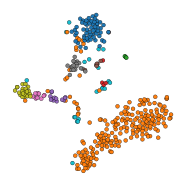

In [120]:
with plt.style.context(cluster_style):
    colors = [v for k, v in cluster_dict.items()]
    plt.figure(figsize=(4.77/2, 4.77/2))
    ax = plt.axes([0., 0., 1., 1.])
    plt.scatter(emb_scaled[:,0], emb_scaled[:,1], c = colors, cmap="tab10", edgecolors="black", s=15, linewidth=0.3)
    plt.xticks([])
    plt.yticks([])

    # Display a graph of the partial correlations
    non_zero = (np.abs(np.triu(S, k=1)) > 0.92 )
    

    # Plot the edges
    start_idx, end_idx = np.where(non_zero)
    segments = [[emb_scaled[start, :], emb_scaled[stop, :]] for start, stop in zip(start_idx, end_idx)]
    lc = LineCollection(segments, zorder=0)
    #ax.add_collection(lc)
    plt.tight_layout()
    #plt.savefig(f"Figures/electricity_best_clustering_edges.pdf", bbox_inches="tight")
    plt.savefig(f"Figures/electricity_best_clustering.pdf", bbox_inches="tight")
    plt.show()

### Visualizing prototypes

In [144]:
prototypes, _, _ = create_prototypes(clusters, dataset_scaled)
cluster_dict = {i: clusters[i] for i in range(len(clusters))}
#plot_index = np.random.randint(0, len_series - length)
plot_index = 24*30*10 - 14*24

In [145]:
length=120
date_range = pd.date_range(start="2012-01-01", periods=dataset_scaled.shape[1], freq="H")
len_series = min([len(p) for p in prototypes.values()])
size=4.77*2
height = 2
scale_plot = True
fill_area = True

In [146]:
from matplotlib import cm
cmap=cm.get_cmap("tab10")
cmap(1.1)

(0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0)

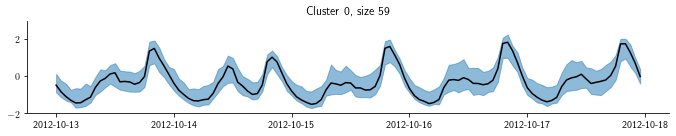

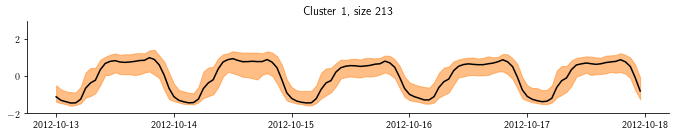

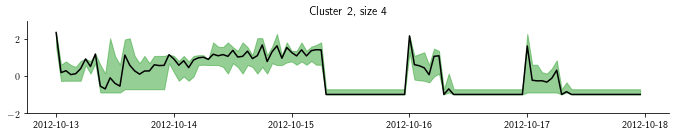

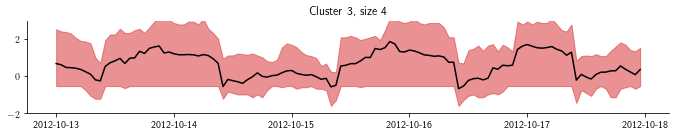

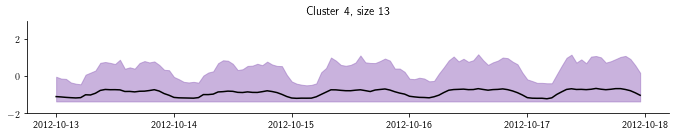

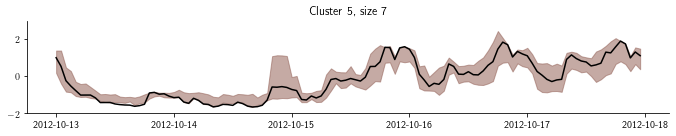

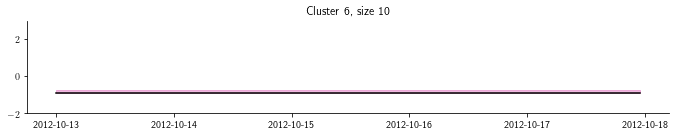

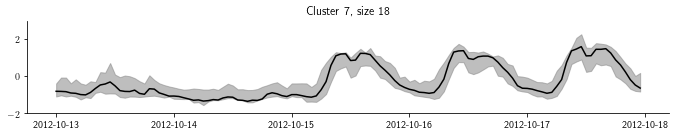

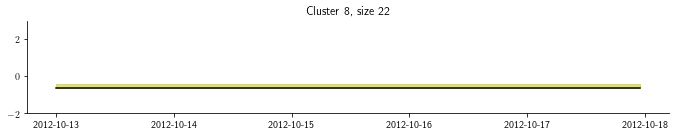

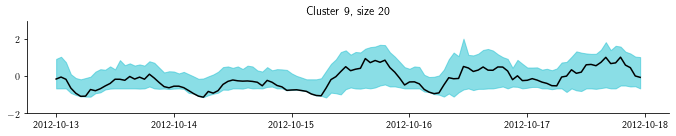

In [148]:
with plt.style.context(ts_style):
    for c in set(cluster_dict.values()):
        p = prototypes[c]
        members = {f"prot_{c}":p}
        for ts in cluster_dict.keys():
            if cluster_dict[ts] == c:
                members[str(ts)] = dataset_unscaled[ts]
        df = pd.DataFrame(members)
        if scale_plot:
            df[df.columns] = StandardScaler().fit_transform(df[df.columns])
        df.index = date_range
        df = df[plot_index : plot_index + length]
        plt.figure(figsize=(size, height))
        if not fill_area:
            rgba_colors = np.zeros((len(df), 4))
            rgba_colors[0,3] = 1
            rgba_colors[1:,3] = 0.1
            df.plot(
                legend=False,
                color=rgba_colors,
                title=f"Cluster {c}, size {len(df.columns)-1}",
                ylim=(-2,4.5)
            )
            plt.tight_layout()
            plt.savefig(f"cluster_all_{c}.pdf", bbox_inches="tight")
            plt.show()
        else:
            std = df.std(axis=1)
            plt.plot(df.index, df[f"prot_{c}"], c="black")
            plt.fill_between(df.index, df.quantile(0.1, axis=1, interpolation="nearest").values, df.quantile(0.9, axis=1, interpolation="nearest").values, color=cmap(c), alpha=0.5)
            plt.title(f"Cluster {c}, size {len(df.columns)-1}")
            plt.ylim((-2, 3))
            plt.tight_layout()
            #plt.savefig(f"Figures/electricity_best_cluster_{c}.pdf", bbox_inches="tight")
            plt.show()